In [1]:
import os
import glob
import cv2
import numpy as np
import pandas as pd

import pyvista as pv
pv.global_theme.trame.server_proxy_enabled = True


from geotransformer.utils.pointcloud import apply_transform

In [2]:
def load_from_bin(bin_path):
    obj = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)
    return obj[:,:3]

def load_from_npy(npy_path):
    obj = np.load(npy_path)
    return obj

In [11]:
# Load Transforms
transforms = np.load('transforms.npy')
gt_transforms = pd.read_csv('data/Rellis/sequences/00/poses.txt', header=None, sep=' ')

# Get all the bin files (Point Clouds)
bin_files = sorted(glob.glob(os.path.join('data/Rellis/sequences/04/vel_cloud_node_kitti_bin/', '*.bin')))
frames = sorted(glob.glob(os.path.join('data/Rellis/sequences/04/pylon_camera_node/', '*.jpg')))

In [7]:
len(bin_files), len(bin_files)

(2056, 2056)

In [12]:
start = 0
end = 63*32
skip = 32


point_cloud = transformed_point_cloud = apply_transform(load_from_bin(bin_files[start]), np.concatenate([gt_transforms.iloc[start].to_numpy().reshape(3,4), np.array([[0,0,0,1]])], axis=0))
for i, bin_file in enumerate(bin_files[start+skip:end:skip]):
    idx = (i + 1) * skip + start
    # Load Point Cloud
    src_point_cloud = load_from_bin(bin_file)
    
    # Get New Transform
    gt_transform = np.concatenate([gt_transforms.iloc[idx].to_numpy().reshape(3,4), np.array([[0,0,0,1]])], axis=0)
    
    # transform = np.matmul(transform, gt_transform)
    transformed_point_cloud = apply_transform(src_point_cloud, gt_transform)
    
    os.makedirs('./reg_pointclouds/gt', exist_ok=True)
    np.save('./reg_pointclouds/gt/{}.npy'.format(i), transformed_point_cloud)
    
    # Read the image
    image_path = frames[idx]
    image = cv2.imread(image_path)

    # Save the image
    os.makedirs('./reg_pointclouds/images', exist_ok=True)
    cv2.imwrite(f'reg_pointclouds/images/{i}.jpg', image)
    
    # Apply Transform
    point_cloud = np.append(point_cloud, transformed_point_cloud, axis=0)#apply_transform(src_point_cloud, transform))

np.save('reg_pointclouds/gt/gt_pointcloud.npy', point_cloud)

transform = np.concatenate([gt_transforms.iloc[idx].to_numpy().reshape(3,4), np.array([[0,0,0,1]])], axis=0)#np.eye(4)
point_cloud = apply_transform(load_from_bin(bin_files[start]), transform)
for i, bin_file in enumerate(bin_files[start+skip:end:skip]):
    # Load Point Cloud
    src_point_cloud = load_from_bin(bin_file)
    
    # Get New Transform
    pred_transform = transforms[i]
    
    transform = np.matmul(pred_transform, transform)
    transformed_point_cloud = apply_transform(src_point_cloud, transform)
    
    os.makedirs('./reg_pointclouds/pred', exist_ok=True)
    np.save('./reg_pointclouds/pred/{}.npy'.format(i), transformed_point_cloud)
    
    # Apply Transform
    point_cloud = np.append(point_cloud, transformed_point_cloud, axis=0)#apply_transform(src_point_cloud, transform))
    
np.save('reg_pointclouds/pred/pred_pointcloud.npy', point_cloud)
    

data/Rellis/sequences/04/pylon_camera_node/frame000032-1581791681_608.jpg
data/Rellis/sequences/04/pylon_camera_node/frame000064-1581791684_808.jpg
data/Rellis/sequences/04/pylon_camera_node/frame000096-1581791688_008.jpg
data/Rellis/sequences/04/pylon_camera_node/frame000128-1581791691_208.jpg
data/Rellis/sequences/04/pylon_camera_node/frame000160-1581791694_408.jpg
data/Rellis/sequences/04/pylon_camera_node/frame000192-1581791697_608.jpg
data/Rellis/sequences/04/pylon_camera_node/frame000224-1581791700_808.jpg
data/Rellis/sequences/04/pylon_camera_node/frame000256-1581791704_008.jpg
data/Rellis/sequences/04/pylon_camera_node/frame000288-1581791707_209.jpg
data/Rellis/sequences/04/pylon_camera_node/frame000320-1581791710_408.jpg
data/Rellis/sequences/04/pylon_camera_node/frame000352-1581791713_608.jpg
data/Rellis/sequences/04/pylon_camera_node/frame000384-1581791716_808.jpg
data/Rellis/sequences/04/pylon_camera_node/frame000416-1581791720_009.jpg
data/Rellis/sequences/04/pylon_camera_

In [9]:
import npy_to_ply
npy_to_ply.main('reg_pointclouds/gt/gt_pointcloud.npy', 'reg_pointclouds/gt/gt_pointcloud.ply')
npy_to_ply.main('reg_pointclouds/pred/pred_pointcloud.npy', 'reg_pointclouds/pred/pred_pointcloud.ply')

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [20]:
pv.start_xvfb()

In [37]:
point_cloud.shape

(655360, 3)

In [34]:
point_cloud.shape

(54518, 3)

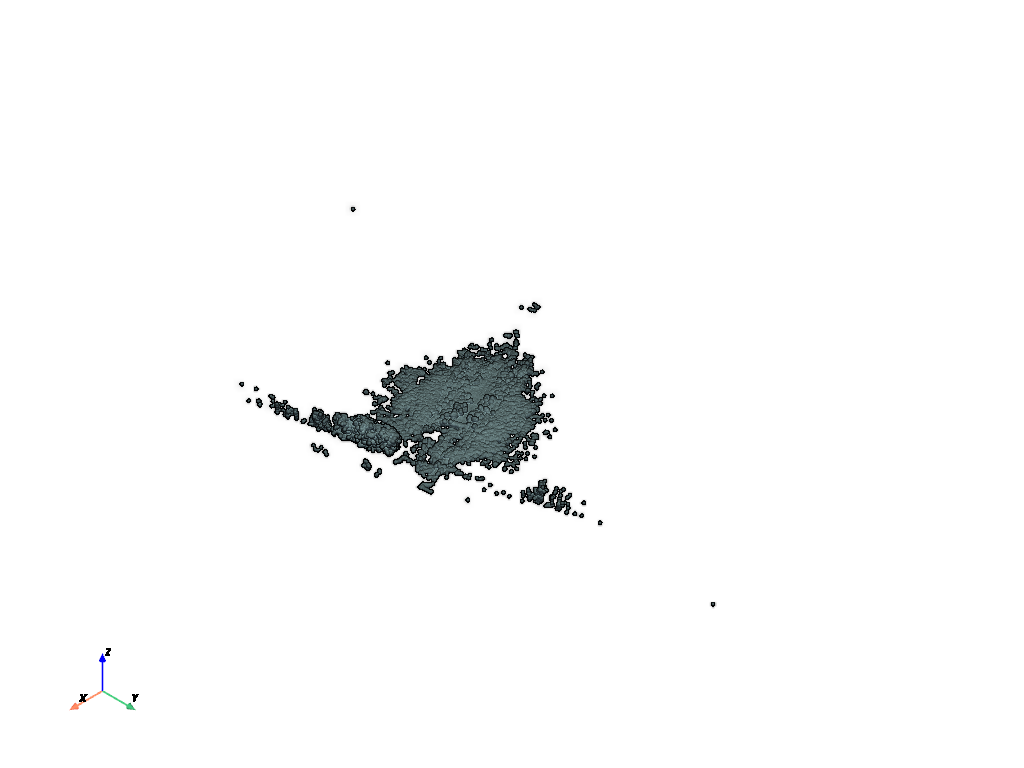

In [40]:
point_cloud_pv = pv.PolyData(point_cloud)
point_cloud_pv.plot(eye_dome_lighting=True, render_points_as_spheres=True, jupyter_backend='static')